## Intro

In this notebook we implement the train rescheduling model presented in [this paper](http://www.csplib.org/Problems/prob078/data/rescheduling.pdf), using [this data](http://www.csplib.org/Problems/prob078/data/) to test our model.

**Description of project**

1] What is the Train Traffic Rescheduling Problem?
* In the railway domain, the action of directing the traffic in accordance with an established
timetable is managed by a software.
* However, in case of real time perturbations, the initial schedule may become infeasible or
suboptimal.
* Subsequent decisions must then be taken manually by an operator in a very limited time in
order to reschedule the traffic and reduce the consequence of the disturbances.
* They can for instance modify the departure time of a train or redirect it to another route.
* Unfortunately, this kind of hazardous decisions can have an unpredicted negative snowball
effect on the delay of subsequent trains

2] What is the goal of our project?
* The Goal is to design a constraint programming model that helps the operators to take more
informed decisions in time

3] How does it relate to the course Material?
* It relates to our discussion of OR-Tools and how it can be used to solve constraint
programming problems
* The project will involve the use of decision variables, resource constraints, and optional
interval variables, all of which are concepts that we discussed in class and implemented through
assignments

**Tentative Plan for Implementing the Project**


1] What tools or techniques will you apply?
* We plan to create a constraint programming model that tries to represent this train traffic
rescheduling problem
* We will use Python and OR-Tools in order to design this model and test it
2] What learning resources will you use to guide you?
* We plan on using this paper Link written by Professors at Universite Catholique de Louvain to
design decision variables, constraints and an objective function that models the Train Traffic
Rescheduling Problem
* We then plan to use the test data and results from the experiments carried out by these
Professors in order to test our model and check if it is accurate (Data available on CSPLIB)

**How should the project be evaluated**

1] How will you test it?
* Test data and results for the experiments carried out using the model proposed in the research
paper are available on CSPLIB
* Using this data we will be able to check if our results match up with those from their
experiments

2] What will be the metric for success?
* The research paper provides results for First Come First Served (FCFS), Highest Delay First
Served (HDFS) and Highest Priority First Served (HPFS) models which are alternatives used to
solve the Train Traffic Rescheduling Problem
* We can compare the value of our objective function to the values obtained using these models
and see if our model does a better job than these models

## Imports, Setup

In [1]:
# Due to some backwards-incompatible differences, please use the latest version of OR-Tools
try:
  import ortools
except:
  !pip install ortools==8.0.8283
if int(ortools.__version__[0]) < 8:
    !pip install ortools==8.0.8283

from ortools.sat.python import cp_model

## Parameters

Two entities are involved in our model: the trains and the track
segments. Table 1 recaps the parameters considered. The speed, number of passengers, and length are straightforward to understand. The estimated arrival
time of a train is a prediction of its arrival time at the station. The earliest start
time defines a lower bound on the starting time of a train. In other words, a
train cannot start its itinerary before this time. Indeed, a train cannot leave its
platform before the time announced to the passengers. The planned completion
time is the time announced on the initial schedule. It defines when the train is
supposed to arrive at a platform. It is used in the objective function in order to compute the delays generated. The category defines the nature of the train.
More explanations about the category is provided in Section 3.

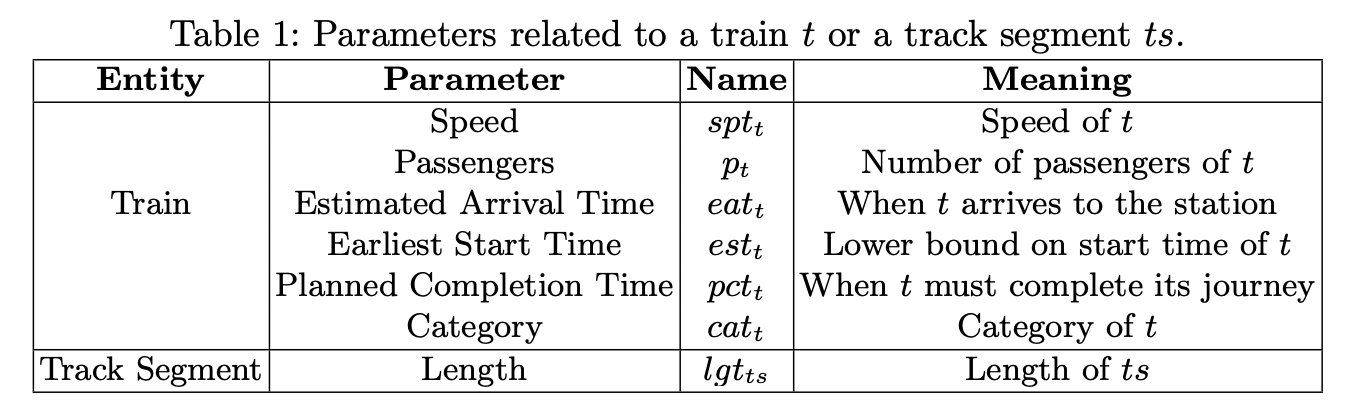

In [2]:
class Train:
  def __init__(self, id: int, spt: int, eat: str, est: str, pct: str, itinerary: str):
    ##we are using only eat
    self.id = id
    self.spt = spt
    self.eat = eat
    self.est = est
    self.pct = pct
    self.itinerary = itinerary

    def __str__():
      return str(f"Train {self.id}")

class RailStation:
  def __init__(self, station_file_path: str, trains_file_path: str):
    self.segments = dict()
    self.routes = dict()
    self.itineraries = dict()
    self.trains = []
    with open(station_file_path) as f:
      wait = False
      for line in f:
        # Parse the station layout file
        if line.strip() == "":
          continue
        elif "/*" in line:
          wait = True
        elif "*/" in line:
          wait = False
          continue
        elif wait:
          continue
        clean_line = line.split("/*")[0].strip()
        if clean_line == "":
          continue
        pieces = clean_line.split(" ")
        if pieces[0] == "[TRACKSEGMENT]":
          assert len(pieces) == 3, f"Line {line} invalid."
          try:
            self.segments[pieces[1]] = int(pieces[2])
          except ValueError:
            raise ValueError(f"Line {line} has invalid segment length.")
        elif pieces[0] == "[ROUTE]":
          route = []
          for piece in pieces[2:]:
            route.append(piece)
          self.routes[pieces[1]] = route
        elif pieces[0] == "[ITINERARY]":
          itinerary = []
          for piece in pieces[2:]: ##we will now have the itinerary as a dictionary
            itinerary.append(piece)
          self.itineraries[pieces[1]] = itinerary
    with open(trains_file_path) as f:
      # Parse the trains file
      wait = False
      for line in f:
        if line.strip() == "":
          continue
        elif "/*" in line:
          wait = True
        elif "*/" in line:
          wait = False
          continue
        elif wait:
          continue
        clean_line = line.split("/*")[0].strip()
        if clean_line == "":
          continue
        pieces = clean_line.split(" ")
        try:
          self.trains.append(Train(int(pieces[0]), int(pieces[1]), self.to_mins(pieces[2]),
                                  self.to_mins(pieces[3]), self.to_mins(pieces[4]), pieces[5]))
        except ValueError:
          raise ValueError(f"Line {line} is invalid.")
    
  def to_mins(self, time_str: str):
    # Changes a time of the form hh:mm or h:mm or hh:m or h:m to integer number of minutes
    assert ":" in time_str
    try:
      pieces = time_str.strip().split(":")
      return int(pieces[0])*60 + int(pieces[1])
    except:
      print("Error")


## Model

Basically, the goal is to schedule
adequately trains in order to bring them to their destination. The decision is then
to chose, for each train, which route must be activated and at what time. Each
track segment can host at most one train at a time. Furthermore, they can also
be reserved only for one train. An inherent component of scheduling problems
are the activities. Roughly speaking, a classical activity A is modelled with three
variables, a start date s(A), a duration d(A) and an end date e(A). The activity
is fixed if the three variables are reduced to a singleton. Our model contains
three kinds of activities that are linked together:

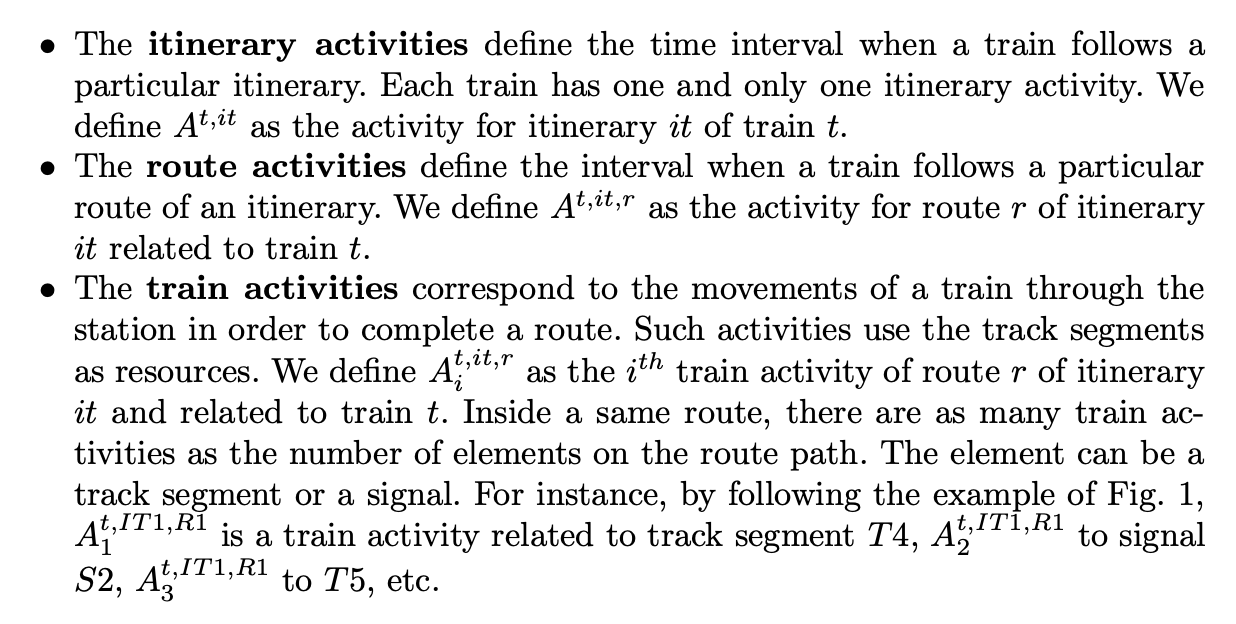

One particularity of our problem is that some activities are optional. In other
words, they may or may not be executed in the final schedule. For instance, let
us assume that a train has to accomplish an itinerary from T4 to T7. To do
so, it can follow either R1, or R2. If R1 is chosen, the activity related to R2
will not be executed. For that, we model optional activities with the conditional
time-interval variables (available in ORTools CPSat through [NewOptionalIntervalVar](https://developers.google.com/optimization/reference/python/sat/python/cp_model#newoptionalintervalvar)) that implicitly encapsulate the notion of optionality. It also allows an efficient propagation through
dedicated global constraints (alternative and span for instance) as well as an
efficient search. Roughly speaking, when an activity is fixed, it can be either
executed, or non executed. If the activity is executed, it behaves as a classical activity that executes on its time interval, otherwise, it is not considered by any
constraint. This functionality is modelled with a new variable x(A) ∈ {0, 1} for
each activity A such that x(A) = 1 if the activity is executed and x(A) = 0
otherwise.

See page 7 of the paper for details about variables for this model (implemented below).

In [3]:
class TrainRescheduler:
    def __init__(self, station, horizon_time, decision_time, constraint_options={}):
      """
      The station parameter is the RailStation object this rescheduler should work with
      The horizon_time parameter is the max time trains can spend at a signal, in minutes
      The decision_time parameter is the max time the solver can spend working on the problem, in seconds
      The constraint_options parameter is a dictionary used for experimentation. Defaults:
        {
          "alternate_no_overlap": True, 
                  # whether to use our alternate formulation of the no overlap constraints
          "dense_precedence_constraint": False, 
                  # whether to use our O(len(route)^2) formulation of this constraint
          "hub_execution_consistency_constraint": True 
                  # whether to use our hub formulation of this constraint rather than our transitive formulation
        }
      """
      # Add parameters
      self.station = station
      self.horizon = horizon_time
      self.decision_time = decision_time
      self.model = cp_model.CpModel()
      self.createX()
      self.createD()
      self.createS()
      self.createE()
      self.createActivities()
      self.createConstraints(**constraint_options)
      self.setObjective()

    def createX(self):
      ##x models whether an activity will take place or not
      model = self.model
      station = self.station
      x = {}
      for t in station.trains:
        it = t.itinerary
        ##the first two elements of a route represent start and end segment
        ##so we start from index 2 instead of 0
        routes = station.itineraries[it][2:]
        for r in routes:
          for i in range(0,len(station.routes[r])):
            x[i+1,t.id,it,r] = model.NewBoolVar(f'x ({i+1},{t.id},{it},{r})')
      self.x = x

    def createD(self):
      ##d models the duration of the activity
      model = self.model
      station = self.station
      d = {}
      for t in station.trains:
        it = t.itinerary
        routes = station.itineraries[it][2:]
        for r in routes:
          route = station.routes[r]
          for i in range(0,len(route)):
            if (route[i][0] == 'S'):
              d[i+1,t.id,it,r] = model.NewIntVar(1, self.horizon,
                                                 f'd({i+1},{t.id},{it},{r})') ##changed from 0 to 1
              d[i+1,t.id,it,r].custom_lower = 1 ##changed from 0 to 1
              d[i+1,t.id,it,r].custom_upper = self.horizon
            else:
              segment = route[i].split(',')[0]
              length = station.segments[segment]
              speed = t.spt
              intBound = (length // speed)
              d[i+1,t.id,it,r] = model.NewIntVar(intBound,intBound, f'd({i+1},{t.id},{it},{r})')
              d[i+1,t.id,it,r].custom_lower = intBound
              d[i+1,t.id,it,r].custom_upper = intBound
      self.d = d
    
    def createS(self):
      ##s models the start of a given activity
      model: cp_model.CpModel = self.model
      station = self.station
      s = {}
      d = self.d
      max_jct = dict() # a dictionary mapping train id to max jct of that train
      for t in station.trains:
        max_jct[t.id] = 0
        it = t.itinerary
        routes = station.itineraries[it][2:]
        for r in routes:
          route = station.routes[r]
          for i in range(0,len(route)):
            ##estimated arrival time and est are identical
            if i==0:
              s[i+1,t.id,it,r] = model.NewIntVar(t.eat, t.eat + self.horizon, 
                                               f's ({i+1},{t.id},{it},{r})')
              s[i+1,t.id,it,r].custom_lower = t.eat
              s[i+1,t.id,it,r].custom_upper = t.eat + self.horizon
            else:
              duration_lower = d[i,t.id,it,r].custom_lower
              duration_upper = d[i,t.id,it,r].custom_upper
              lower = s[i,t.id,it,r].custom_lower + duration_lower
              upper = s[i,t.id,it,r].custom_upper + duration_upper
              s[i+1,t.id,it,r] = model.NewIntVar(lower, upper, 
                                                f's ({i+1},{t.id},{it},{r})')
              s[i+1,t.id,it,r].custom_lower = lower
              s[i+1,t.id,it,r].custom_upper = upper
            if s[i+1,t.id,it,r].custom_upper > max_jct[t.id]:
              max_jct[t.id] = s[i+1,t.id,it,r].custom_upper
      self.max_jct = max_jct 
      self.s = s
    
    def createE(self):
      ##e models the end of the activity
      model = self.model
      station = self.station
      s = self.s
      d = self.d
      e = dict()
      for t in station.trains:
        it = t.itinerary
        routes = station.itineraries[it][2:]
        for r in routes:
          route = station.routes[r]
          for i in range(0,len(route)):
            lower = s[i+1,t.id,it,r].custom_lower + d[i+1,t.id,it,r].custom_lower
            upper = s[i+1,t.id,it,r].custom_upper + d[i+1,t.id,it,r].custom_upper
            e[i+1,t.id,it,r] = model.NewIntVar(lower, upper, f'e({i+1},{t.id},{it},{r})')
            e[i+1,t.id,it,r].custom_lower = lower
            e[i+1,t.id,it,r].custom_upper = upper
      self.e = e
    
    def createActivities(self):
      ##this function creates activities using NewOptionalIntervalVar
      ##start: s; end: e; duration: d; boolean: x
      model = self.model
      station = self.station
      train_activities = dict()
      route_activities = dict()
      for t in station.trains:
        it = t.itinerary
        routes = station.itineraries[it][2:]
        for r in routes:
          route = station.routes[r]
          # model.NewIntervalVar(start_var, duration, end_var, name)
          for i in range(0,len(route)):
            train_activities[i+1,t.id,it,r] = model.NewOptionalIntervalVar(self.s[i+1,t.id,it,r], 
                                                                     self.d[i+1,t.id,it,r], 
                                                                     self.e[i+1,t.id,it,r], 
                                                                     self.x[i+1,t.id,it,r], 
                                                                     f"A({i+1},{t.id},{it},{r})")
            train_activities[i+1,t.id,it,r].start = self.s[i+1,t.id,it,r]
            train_activities[i+1,t.id,it,r].duration = self.d[i+1,t.id,it,r]
            train_activities[i+1,t.id,it,r].end = self.e[i+1,t.id,it,r]
      self.activities = train_activities
      # self.route_activities = route_activities


## Constraints

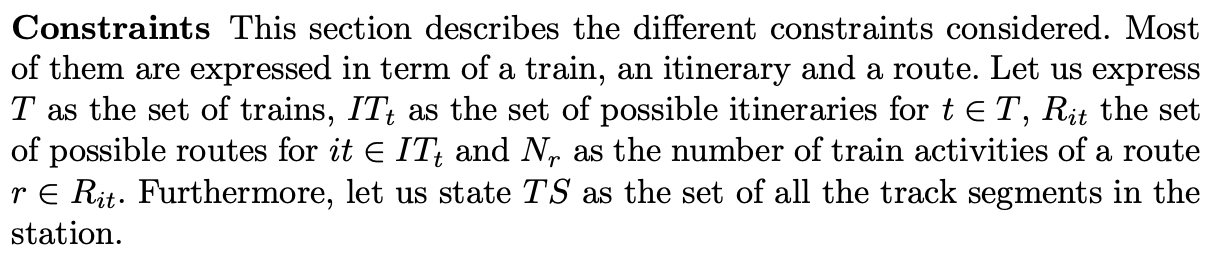

See page 8 of the paper for details about constraints for this model (implemented below).

In [4]:
def precedenceConstraint(self, dense_constraint=False):
  """
  The dense_constraint parameter can be used to enable an experimental 
  O(len(route)^2) constraint formulation of this set of constraints
  rather than O(len(route)).  We found that enabling this constraint 
  does not improve solve time, and in fact significantly increases it.
  """
  ##Constraint 5 - Precedence e(A(i,t,it,r)) = s(A(i+1,t,it,r))
  model: cp_model.CpModel = self.model
  station = self.station
  e = self.e
  s = self.s
  d = self.d
  for t in station.trains:
    it = t.itinerary
    routes = station.itineraries[it][2:]
    for r in routes:
      route = station.routes[r]
      for i in range(0,len(route)-1):
        if not dense_constraint:
          model.Add(e[i+1,t.id,it,r] == s[i+2,t.id,it,r])
        else:
          for j in range(i+1, len(route)):
            sum_d = model.NewIntVar(sum([d[k,t.id,it,r].custom_lower for k in range(i+2, j+1)]),
                                    sum([d[k,t.id,it,r].custom_upper for k in range(i+2, j+1)]),
                                    f"sum_d for [{i+2}:{j+1})")
            model.Add(sum_d == sum([d[k,t.id,it,r] for k in range(i+2, j+1)]))
            model.Add(s[j+1,t.id,it,r] - e[i+1,t.id,it,r] == sum([d[k,t.id,it,r] for k in range(i+2, j+1)]))

TrainRescheduler.precedenceConstraint = precedenceConstraint

Consider this quote from the article:

All precedence constraints are aggregated into a temporal network in order
to have a better propagation [24, 34]. Instead of having a bunch of independent
constraints, they are considered as a global constraint.

In [5]:
def executionConsistencyConstraint(self, hub_constraint=False):
  """
  The dense_constraint parameter can be used to enable an experimental 
  O(len(route)^2) constraint formulation of this set of constraints
  rather than O(len(route)).  We found that enabling this constraint 
  slightly improves solve time.
  """
  ##Constraint 6 - x(A(1,t,it,r)) = x(A(i,t,it,r))
  model: cp_model.CpModel = self.model
  station = self.station
  x = self.x
  for t in station.trains:
    it = t.itinerary
    routes = station.itineraries[it][2:]
    for r in routes:
      route = station.routes[r]
      for i in range(0, len(route)):
        if hub_constraint:
          model.Add(x[1,t.id,it,r] == x[i+1,t.id,it,r])
        else:
          if i == len(route) - 1:
            continue
          model.Add(x[i+1,t.id,it,r] == x[i+2,t.id,it,r])

TrainRescheduler.executionConsistencyConstraint = executionConsistencyConstraint

^^ should we add all O(n^2) edges, i.e. make this a complete graph of equality constraints?  If more constraints are better then maybe this is a good idea...

In [6]:
def alternativeConstraint(self):
  ##Constraint 7 - Each train must take exactly one route to execute the itinerary
  ##exec Consistency already enforces that all activities are 0 or all are 1

  ##Logic: if route r is being executed x[1,t.id,it,r] has to be one and if not then it has to be 0

  model: cp_model.CpModel = self.model
  station = self.station
  x = self.x
  for t in station.trains:
    it = t.itinerary
    routes = station.itineraries[it][2:]
    model.Add(sum(x[1,t.id,it,r] for r in routes) == 1)
  
TrainRescheduler.alternativeConstraint = alternativeConstraint

In [7]:
def noOverlapConstraint(self):
  ##Constraint 9 - a track segment cannnot have two active activities at the same time
  model: cp_model.CpModel = self.model
  station = self.station
  segments = station.segments
  activities = self.activities
  for segment in segments.keys():
    activities_for_this_seg = dict()
    for t in station.trains:
      it = t.itinerary
      routes = station.itineraries[it][2:]
      for r in routes:
        route = station.routes[r]
        for i in range(0,len(route)):
          if segment in station.routes[r][i].split(","):
            activities_for_this_seg[f"a({i+1},{t.id},{it},{r})"] = activities[i+1,t.id,it,r]
    model.AddNoOverlap(list(activities_for_this_seg.values()))
  
TrainRescheduler.noOverlapConstraint = noOverlapConstraint

In [8]:
def alternatenoOverlapConstraint(self):
  model: cp_model.CpModel = self.model
  station = self.station
  segments = station.segments
  activities = self.activities
  for segment in segments.keys():
    activities_for_this_seg = dict()
    for t in station.trains:
      it = t.itinerary
      routes = station.itineraries[it][2:]
      for r in routes:
        route = station.routes[r]
        for i in range(0,len(route)-1): ##destination segment is not part of route
        ##for i in range(0,len(route)):
          if (route[i][0] == 'S' and i == 1): ##skip for the first signal
            continue
          if segment in station.routes[r][i].split(","):
            activities_for_this_seg[f"a({i+1},{t.id},{it},{r})"] = activities[i+1,t.id,it,r]
    model.AddNoOverlap(list(activities_for_this_seg.values()))
  
TrainRescheduler.alternatenoOverlapConstraint = alternatenoOverlapConstraint

In [9]:
def trainOrderConsistencyConstraint(self):
  ##Constraint 10- trains cannot overtake other trains on the track segment that comes before the signal
  model: cp_model.CpModel = self.model
  station = self.station
  TSB = set()
  for t in station.trains:
    it = t.itinerary
    TSB.add(station.itineraries[it][0])
  
  for tsb in TSB:
    trains = [t for t in station.trains if station.itineraries[t.itinerary][0] == tsb]
    sorted_trains = sorted(trains, key=(lambda x: x.eat))
    for i in range(len(sorted_trains)):
      for j in range(i+1, len(sorted_trains)):
        t1 = sorted_trains[i]
        t2 = sorted_trains[j]
        it1 = t1.itinerary
        it2 = t2.itinerary
        routes1 = station.itineraries[it1][2:]
        routes2 = station.itineraries[it2][2:]
        for r1 in routes1:
          for r2 in routes2:
            both_active = model.NewBoolVar(f"(x(1,{t1.id},{it1},{r1}) + x(1,{t2.id},{it2},{r2}) == 2)")
            model.Add(self.x[1,t1.id,it1,r1] + self.x[1,t2.id,it2,r2] == 2).OnlyEnforceIf(both_active)
            model.Add(self.x[1,t1.id,it1,r1] + self.x[1,t2.id,it2,r2] < 2).OnlyEnforceIf(both_active.Not())
            model.Add(self.s[1,t1.id,it1,r1] < self.s[1,t2.id,it2,r2]).OnlyEnforceIf(both_active)

TrainRescheduler.trainOrderConsistencyConstraint = trainOrderConsistencyConstraint

In [10]:
def createConstraints(self, 
                      alternate_no_overlap=True, 
                      dense_precedence_constraint=False,
                      hub_execution_consistency_constraint=False):
  """
  The alternate_no_overlap parameter can be set to True to use our alternate formulation 
  of the no overlap constraints. In experimentation the alternate no overlap constraints 
  yielded significantly faster solve time.
  """
  self.precedenceConstraint(dense_constraint=dense_precedence_constraint)
  self.executionConsistencyConstraint(hub_constraint=hub_execution_consistency_constraint)
  self.alternativeConstraint()
  if alternate_no_overlap:
    self.alternatenoOverlapConstraint()
  else:
    self.noOverlapConstraint()
  self.trainOrderConsistencyConstraint()

TrainRescheduler.createConstraints = createConstraints

In [11]:
def setObjective(self):
  model: cp_model.CpModel = self.model
  station = self.station
  duration = dict()
  s = self.s
  # e = self.e
  x = self.x
  delay_candidates = []
  for t in self.station.trains:
    duration[t.id] = model.NewIntVar(0, self.max_jct[t.id] - t.pct, f'd_{t.id}')
    # ^^^ max_jct[t.id] is the maximum of the end time of the last activity across all routes in the itinerary of t
    it = t.itinerary
    routes = station.itineraries[it][2:]
    for r in routes:
      route = station.routes[r]
      signed_delay = model.NewIntVar(s[len(route),t.id,it,r].custom_lower - t.pct, 
                                     s[len(route),t.id,it,r].custom_upper - t.pct, 
                                     f"(s[{len(route)},{t.id},{it},{r}] - {t.pct})")
      model.Add(s[len(route),t.id,it,r] - t.pct == signed_delay)
      # ^^^ signed_delay = jct[t] - t.pct
      upper = max(s[len(route),t.id,it,r].custom_upper - t.pct, 0)
      unconditional_delay = model.NewIntVar(0, upper, f"max(0, (s[{len(route)},{t.id},{it},{r}] - {t.pct}))")
      model.AddMaxEquality(unconditional_delay, [0, signed_delay])
      # ^^^ unconditional_delay = max(0, signed_delay)
      weighted_duration = model.NewIntVar(0, upper, f"(d_{t.id} if x({len(route)},{t.id},{it},{r}) else 0)")
      weighted_duration.custom_upper = upper
      model.AddMultiplicationEquality(weighted_duration, [x[len(route),t.id,it,r], unconditional_delay])
      # ^^^ weighted_duration = x[len(route),t.id,it,r] * unconditional_delay
      delay_candidates.append(weighted_duration)
  
  self.objective = model.NewIntVar(
      0, 
      sum([candidate.custom_upper for candidate in delay_candidates]), 
      "objective"
  )
  model.Add(sum(delay_candidates) == self.objective)
  model.Minimize(self.objective)

TrainRescheduler.setObjective = setObjective

In [12]:
def inverse_to_mins(minutes: int):
    # Changes an integer number of minutes to a time string of the form hh:mm or h:mm or hh:m or h:m
    mins = minutes % 60
    hours = minutes // 60
    return f"{hours}:{mins}"

def solve_and_print(self, parallelized_num_workers=None, print_solution=True):
  """
  The parallelized_num_workers parameter can be used to experiment with parallelization; set 
  it to None to disable parallelization and set it to an integer to enable 
  parallelization and set the number of workers.
  """
  station = self.station
  x = self.x
  s = self.s
  d = self.d
  e = self.e
  self.solver = cp_model.CpSolver()
  solver = self.solver
  # Sets a time limit of decision_time
  solver.parameters.max_time_in_seconds = self.decision_time
  if parallelized_num_workers is not None:
    solver.parameters.num_search_workers = parallelized_num_workers
  self.solution = self.solver.Solve(self.model)
  solution = self.solution
  self.solution_dict = dict()
  solution_dict = self.solution_dict
  solution_dict['x'] = dict()
  solution_dict['s'] = dict()
  solution_dict['d'] = dict()
  solution_dict['e'] = dict()
  if solution == cp_model.FEASIBLE or solution == cp_model.OPTIMAL:
    if print_solution:
      print("Activity Values:")
    for t in station.trains:
      it = t.itinerary
      routes = station.itineraries[it][2:]
      for r in routes:
        route = station.routes[r]
        for i in range(0,len(route)):
          solution_dict['x'][i+1,t.id,it,r] = solver.Value(x[i+1,t.id,it,r])
          if solver.Value(x[i+1,t.id,it,r]) == 0:
            if print_solution:
              print(f"\tA({i+1},{t.id},{it},{r}): NOT ACTIVE")
          else:
            solution_dict['s'][i+1,t.id,it,r] = solver.Value(s[i+1,t.id,it,r])
            solution_dict['d'][i+1,t.id,it,r] = solver.Value(d[i+1,t.id,it,r])
            solution_dict['e'][i+1,t.id,it,r] = solver.Value(e[i+1,t.id,it,r])
            if print_solution:
              print(f"\ts({i+1},{t.id},{it},{r}) = {inverse_to_mins(solver.Value(s[i+1,t.id,it,r]))}, "
                    f"e({i+1},{t.id},{it},{r}) = {inverse_to_mins(solver.Value(e[i+1,t.id,it,r]))}")
    print(solver.ResponseStats())
  else:
    if solution == cp_model.MODEL_INVALID:
      print("Model invalid:")
      print(self.model.Validate())
    else:
      print("No feasible solution found")
      print(solver.ResponseStats())
      print(self.model.Validate())
    return None
  return solution_dict

TrainRescheduler.solve_and_print = solve_and_print

In [13]:
def check_solution_satisfies_constraints(station, solution_dict):
  """
  This function is used to independently check that found solutions 
  actually satisfy the constraints of the problem 
  (used to make sure the constraints were properly represented in the solver).
  """

  for t in station.trains:
    it = t.itinerary
    routes = station.itineraries[it][2:]
    total = sum([solution_dict['x'][1,t.id,it,r] for r in routes])
    if total != 1:
        # Alternative
        print(f"Alternative constraint violated; sum([x[1,{t.id},{it},r] for r in routes]) = {total} != 1")
        return False
    for r in routes:
      route = station.routes[r]
      for i in range(0, len(route) - 1):
        # Execution Consistency
        if solution_dict['x'][i+1,t.id,it,r] != solution_dict['x'][i+2,t.id,it,r]:
          print(f"Execusion consistency constraint violated; x{str([i+1,t.id,it,r])} != x{str([i+2,t.id,it,r])}")
          return False
      if not solution_dict['x'][1,t.id,it,r]:
        continue
      for i in range(0, len(route) - 1):
        # Precedence
        if solution_dict['e'][i+1,t.id,it,r] != solution_dict['s'][i+2,t.id,it,r]:
          print(f"Precedence constraint violated; e{str([i+1,t.id,it,r])} != s{str([i+2,t.id,it,r])}")
          return False
        if solution_dict['d'][i+1,t.id,it,r] < 0:
          print(f"d{str([i+1,t.id,it,r])} < 0")
          return False
        if solution_dict['d'][i+1,t.id,it,r] != solution_dict['e'][i+1,t.id,it,r] - solution_dict['s'][i+1,t.id,it,r]:
          print(f"d != e-s for {str([i+1,t.id,it,r])}")
          return False
  
  # Unary resource
  activity_segments = dict()
  for t in station.trains:
    it = t.itinerary
    for r in station.itineraries[it][2:]:
      route = station.routes[r]
      for i in range(0,len(route)):
        seg = route[i]
        if seg[0].lower() == 's':
          # Overlap doesn't matter for signals (see the paper)
          continue
        if seg == station.itineraries[it][1]:
          # Overlap doesn't matter for first track segments (see the paper)
          continue
        if seg not in activity_segments:
          activity_segments[seg] = []
        solution_dict['x'][i+1,t.id,it,r]
        activity_segments[seg].append([i+1,t.id,it,r])
  for k, v in activity_segments.items():
    activities = [ac for ac in v if solution_dict['x'][ac[0], ac[1], ac[2], ac[3]]]
    sorted_by_end = sorted(activities, key=lambda x: solution_dict['e'][x[0], x[1], x[2], x[3]])
    for i in range(len(sorted_by_end)):
      for j in range(i+1, len(sorted_by_end)):
        aj = sorted_by_end[j]
        ai = sorted_by_end[i]
        si = solution_dict['e'][ai[0], ai[1], ai[2], ai[3]]
        ei = solution_dict['e'][ai[0], ai[1], ai[2], ai[3]]
        sj = solution_dict['s'][aj[0], aj[1], aj[2], aj[3]]
        ej = solution_dict['e'][aj[0], aj[1], aj[2], aj[3]]
        if sj < ei:
          # Unary resource
          print(f"Unary resource constraint violated for {str([aj[0], aj[1], aj[2], aj[3]])} "
                f"and {[ai[0], ai[1], ai[2], ai[3]]};")
          print(f"Train {i} reserves {k} from {si} to {ei}")
          print(f"Train {i} reserves {k} from {sj} to {ej}")
          return False

  # Train order consistency
  TSB = set()
  for t in station.trains:
    it = t.itinerary
    TSB.add(station.itineraries[it][0])
  for tsb in TSB:
    trains = [t for t in station.trains if station.itineraries[t.itinerary][0] == tsb]
    sorted_trains = sorted(trains, key=(lambda x: x.eat))
    for i in range(len(sorted_trains)):
      for j in range(i+1, len(sorted_trains)):
        t1 = sorted_trains[i]
        t2 = sorted_trains[j]
        it1 = t1.itinerary
        it2 = t2.itinerary
        routes1 = station.itineraries[it1][2:]
        routes2 = station.itineraries[it2][2:]
        for r1 in routes1:
          if not solution_dict['x'][1,t1.id,it1,r1]:
            continue
          for r2 in routes2:
            if not solution_dict['x'][1,t2.id,it2,r2]:
              continue 
            if solution_dict['s'][1,t1.id,it1,r1] >= solution_dict['s'][1,t2.id,it2,r2]:
              # Train order consistency
              print(f"Train order consistency constraint violated; s{[str([1,t1.id,it1,r1])]} "
                    f">= s{str([1,t2.id,it2,r2])}")
              return False
    return True
  

In [14]:
courtrai_station = RailStation("courtrai_layout.txt", "courtrai_instance_homo_5_1.dat")

# horizon time in mins, decision time in seconds
train_scheduler = TrainRescheduler(
    courtrai_station, horizon_time=120, decision_time=180, 
    constraint_options={
    "alternate_no_overlap": False, 
    "dense_precedence_constraint": False, 
    "hub_execution_consistency_constraint": False 
    }
  )

solution = train_scheduler.solve_and_print(parallelized_num_workers=None, print_solution=False)
print("Solution valid: ", str(check_solution_satisfies_constraints(courtrai_station, solution)))

CpSolverResponse:
status: OPTIMAL
objective: 282
best_bound: 282
booleans: 591
conflicts: 36501
branches: 67110
propagations: 1611230
integer_propagations: 7465584
walltime: 6.20794
usertime: 6.20794
deterministic_time: 0.471808
primal_integral: 0

Solution valid:  True


In [15]:
courtrai_station = RailStation("courtrai_layout.txt", "courtrai_instance_homo_5_1.dat")

# horizon time in mins, decision time in seconds
train_scheduler = TrainRescheduler(
    courtrai_station, horizon_time=120, decision_time=180, 
    constraint_options={
    "alternate_no_overlap": True, 
    "dense_precedence_constraint": False, 
    "hub_execution_consistency_constraint": False 
    }
  )

solution = train_scheduler.solve_and_print(parallelized_num_workers=None, print_solution=False)
print("Solution valid: ", str(check_solution_satisfies_constraints(courtrai_station, solution)))

CpSolverResponse:
status: OPTIMAL
objective: 282
best_bound: 282
booleans: 362
conflicts: 1079
branches: 5270
propagations: 48678
integer_propagations: 137954
walltime: 0.147099
usertime: 0.147099
deterministic_time: 0.00688505
primal_integral: 0

Solution valid:  True


In [16]:
courtrai_station = RailStation("courtrai_layout.txt", "courtrai_instance_homo_5_1.dat")

# horizon time in mins, decision time in seconds
train_scheduler = TrainRescheduler(
    courtrai_station, horizon_time=120, decision_time=180, 
    constraint_options={
    "alternate_no_overlap": False, 
    "dense_precedence_constraint": True, 
    "hub_execution_consistency_constraint": False 
    }
  )

solution = train_scheduler.solve_and_print(parallelized_num_workers=None, print_solution=False)
print("Solution valid: ", str(check_solution_satisfies_constraints(courtrai_station, solution)))

CpSolverResponse:
status: OPTIMAL
objective: 282
best_bound: 282
booleans: 594
conflicts: 293394
branches: 361686
propagations: 19716346
integer_propagations: 66949399
walltime: 46.4053
usertime: 46.4053
deterministic_time: 6.73908
primal_integral: 0

Solution valid:  True


In [17]:
courtrai_station = RailStation("courtrai_layout.txt", "courtrai_instance_homo_5_1.dat")

# horizon time in mins, decision time in seconds
train_scheduler = TrainRescheduler(
    courtrai_station, horizon_time=120, decision_time=180, 
    constraint_options={
    "alternate_no_overlap": False, 
    "dense_precedence_constraint": False, 
    "hub_execution_consistency_constraint": True 
    }
  )

solution = train_scheduler.solve_and_print(parallelized_num_workers=None, print_solution=False)
print("Solution valid: ", str(check_solution_satisfies_constraints(courtrai_station, solution)))

CpSolverResponse:
status: OPTIMAL
objective: 282
best_bound: 282
booleans: 591
conflicts: 36501
branches: 67110
propagations: 1611230
integer_propagations: 7465584
walltime: 6.30429
usertime: 6.30429
deterministic_time: 0.471808
primal_integral: 0

Solution valid:  True


In [18]:
courtrai_station = RailStation("courtrai_layout.txt", "courtrai_instance_homo_10_1.dat")

# horizon time in mins, decision time in seconds
train_scheduler = TrainRescheduler(
    courtrai_station, horizon_time=120, decision_time=180, 
    constraint_options={
    "alternate_no_overlap": True, 
    "dense_precedence_constraint": False, 
    "hub_execution_consistency_constraint": False 
    }
  )

solution = train_scheduler.solve_and_print(parallelized_num_workers=6, print_solution=False)
print("Solution valid: ", str(check_solution_satisfies_constraints(courtrai_station, solution)))

CpSolverResponse:
status: FEASIBLE
objective: 904
best_bound: 656
booleans: 1922
conflicts: 124845
branches: 259588
propagations: 14539060
integer_propagations: 29007564
walltime: 180.005
usertime: 180.005
deterministic_time: 30.4022
primal_integral: 167.622

Solution valid:  True


In [19]:
courtrai_station = RailStation("courtrai_layout.txt", "courtrai_instance_homo_30_1.dat")

# horizon time in mins, decision time in seconds
train_scheduler = TrainRescheduler(
    courtrai_station, horizon_time=500, decision_time=180, 
    constraint_options={
    "alternate_no_overlap": True, 
    "dense_precedence_constraint": False, 
    "hub_execution_consistency_constraint": False 
    }
  )

solution = train_scheduler.solve_and_print(parallelized_num_workers=6, print_solution=False)
print("Solution valid: ", str(check_solution_satisfies_constraints(courtrai_station, solution)))

CpSolverResponse:
status: FEASIBLE
objective: 10343
best_bound: 664
booleans: 7182
conflicts: 7988
branches: 783116
propagations: 7671070
integer_propagations: 11747763
walltime: 180.01
usertime: 180.01
deterministic_time: 13.2362
primal_integral: 121.659

Solution valid:  True


# **Debugging Tools Below**

In [20]:
# Check variable bounds 

model = train_scheduler.model
station = train_scheduler.station
s = train_scheduler.s
d = train_scheduler.d
e = train_scheduler.e
for t in station.trains:
  it = t.itinerary
  routes = station.itineraries[it][2:]
  for r in routes:
    route = station.routes[r]
    for i in range(0,len(route)):
      print(f's({i+1},{t.id},{it},{r}) is in [{inverse_to_mins(s[i+1,t.id,it,r].custom_lower)}, {inverse_to_mins(s[i+1,t.id,it,r].custom_upper)}]')
      print(f'd({i+1},{t.id},{it},{r}) is in [{d[i+1,t.id,it,r].custom_lower}, {d[i+1,t.id,it,r].custom_upper}]')
      print(f'e({i+1},{t.id},{it},{r}) is in [{inverse_to_mins(e[i+1,t.id,it,r].custom_lower)}, {inverse_to_mins(e[i+1,t.id,it,r].custom_upper)}]')

s(1,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:0, 20:20]
d(1,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [11, 11]
e(1,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:11, 20:31]
s(2,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:11, 20:31]
d(2,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [1, 500]
e(2,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:12, 28:51]
s(3,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:12, 28:51]
d(3,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [11, 11]
e(3,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:23, 29:2]
s(4,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:23, 29:2]
d(4,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [11, 11]
e(4,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:34, 29:13]
s(5,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:34, 29:13]
d(5,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [11, 11]
e(5,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:45, 29:24]
s(6,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:45, 29:24]
d(6,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [11, 11]
e(6,0,IT_MXD_ED,R_MXD_ED_via_T_15) is in [12:56, 29:35]
s(7,0,IT_MXD_ED,R_MXD_ED_via_T_